### Setup
1. Imports the necessary libraries
2. Sets the list of relevant class names. These will be the classes of annotaters that are fit using the meal_annotation_plus_2hr_meal.csv data.


**This code uses the meal_annotation_plus_2hr_meal.csv data!**


In [10]:
import os
import importlib
import inspect
import sktime.annotation as ann
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import yaml
from sktime.datatypes._panel._convert import from_2d_array_to_nested

# List of relevant class names
relevant_class_names = [
    "ClaSPSegmentation", # this is univariate so might need different preprocessing
    "EAgglo",
    "GaussianHMM",
    "GMMHMM",
    "GreedyGaussianSegmentation",
    "HMM",
    "InformationGainSegmentation",
    "PoissonHMM",
    "STRAY",
    "ClusterSegmenter"
]




### Functions for loading the model classes and model configs
These functions are used to load the model classes and model configs from the sktime annotation module and a yaml file, respectively.
For example, it loads the model classes from sktime annotation module from the given list of strings in relevant_class_names.
Also, loads the yaml file containing the model configs to set hyperparameters for each model.


In [11]:
# List to store the relevant classes
model_classes = []

def find_relevant_classes_in_module(module):
    """
    Search for relevant classes in a given module and add them to the model_classes list.
    """
    for name, obj in inspect.getmembers(module, inspect.isclass):
        if name in relevant_class_names:  # Check if the class is relevant
            model_classes.append(obj)  # Save the class reference

def import_relevant_classes():
    """
    imports classes from sktime.annotation based on the relevant_class_names list
    """
    annotation_path = os.path.dirname(ann.__file__)  # Get the folder path

    # Loop through all .py files in the annotation folder
    for filename in os.listdir(annotation_path):
        if filename.endswith(".py") and filename != "__init__.py":  # Ignore __init__.py
            module_name = f"sktime.annotation.{filename[:-3]}"  # Convert filename to module name
            
            try:
                # Import the module dynamically
                module = importlib.import_module(module_name)
                find_relevant_classes_in_module(module)  # Search for relevant classes
            except ImportError as e:
                print(f"Could not import {module_name}: {e}")


def load_model_configs():
    with open('model_configs.yaml', 'r') as file:
        return yaml.safe_load(file)

### Model Configs and Model ClassesLoading
1. Loads the model classes from sktime (imports the relevant models, as per the relevant_class_names list)
2. Loads the model configs from the yaml file (for example, hyperparameters for each model)
3. Sets the number of days for segmentation specified per the yaml file


In [12]:

# Run the function to import relevant classes
import_relevant_classes()

model_configs = load_model_configs()

num_days = model_configs.get('general', {}).get('num_days', 7) 

### Some loading and preprocessing Functions
1. load_and_preprocess_data
2. visualize_segmentation
3. create_meal_labels


In [13]:
def load_and_preprocess_data(num_days):
    """
    Load and preprocess the data
    """
    df = pd.read_csv("../data/interim/meal_annotation_plus_2hr_meal.csv", parse_dates=['day_4am'])

    # Sort by day_4am, then reset index to use row number as timestep
    df = df.sort_values('day_4am').reset_index(drop=True)
    df.drop(columns=['Unnamed: 0'], inplace=True)

    # Handle NaN values
    df['bgl'] = df['bgl'].fillna(method='ffill')
    df['dose_units'] = df['dose_units'].fillna(0)
    df['food_g'] = df['food_g'].fillna(0)

    # Create meal segment labels
    df['meal_segment'] = create_meal_labels(df)

    # Select a timeframe based on num_days
    unique_days = pd.to_datetime(df['day_4am']).dt.floor('D').unique()
    start_day = np.random.choice(unique_days[:-num_days])
    end_day = start_day + pd.Timedelta(days=num_days)
    df = df[(df['day_4am'] >= start_day) & (df['day_4am'] < end_day)]

    # Prepare X and y
    X = df.drop(columns=[col for col in df.columns if 'msg_type' in col or col == 'meal_segment' or col == 'day_4am'])
    y = df['meal_segment']

    return X, y

def visualize_segmentation(X, y_true, y_pred, column_name='bgl', title='Segmentation Comparison'):
    """
    Visualize the true and predicted segmentation results in separate plots.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), sharex=True)
    
    # Plot for true segmentation
    ax1.plot(X.index, X[column_name], label=column_name, alpha=0.7)
    for cp in np.where(np.diff(y_true) != 0)[0]:
        ax1.axvline(x=X.index[cp], color='g', linestyle='--', alpha=0.5, label='True Segment' if cp == np.where(np.diff(y_true) != 0)[0][0] else '')
    ax1.set_title(f'{title} - True Segmentation')
    ax1.set_ylabel(column_name)
    ax1.legend()
    
    # Plot for predicted segmentation
    ax2.plot(X.index, X[column_name], label=column_name, alpha=0.7)
    for cp in np.where(np.diff(y_pred) != 0)[0]:
        ax2.axvline(x=X.index[cp], color='r', linestyle=':', alpha=0.5, label='Predicted Segment' if cp == np.where(np.diff(y_pred) != 0)[0][0] else '')
    ax2.set_title(f'{title} - Predicted Segmentation')
    ax2.set_xlabel('Time')
    ax2.set_ylabel(column_name)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def create_meal_labels(df):
    """
    Create meal segment labels as in notebook 1.02
    """
    labels = np.zeros(len(df))
    meal_start = df['msg_type'] == 'ANNOUNCE_MEAL'
    meal_end = df['msg_type'] == 'MEAL_END'
    
    meal_counter = 1
    active_meals = []
    
    for i in range(len(df)):
        if meal_start.iloc[i]:
            active_meals.append(meal_counter)
            meal_counter += 1
        
        if len(active_meals) > 0:
            labels[i] = active_meals[-1]
        
        if meal_end.iloc[i] and len(active_meals) > 0:
            active_meals.pop()
    
    return labels

### The Training Loop
Loops through all the models and visualizes the segmentation results. 
Compares the true and predicted segmentation results.


C:\Users\viloh\AppData\Local\Temp\ipykernel_13864\664700858.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['bgl'] = df['bgl'].fillna(method='ffill')


Collected 1 relevant classes:
- GreedyGaussianSegmentation
  Instantiated with config: {'k_max': 10}
Starting fit
  Successfully fit GreedyGaussianSegmentation to the data
  Successfully predicted with GreedyGaussianSegmentation


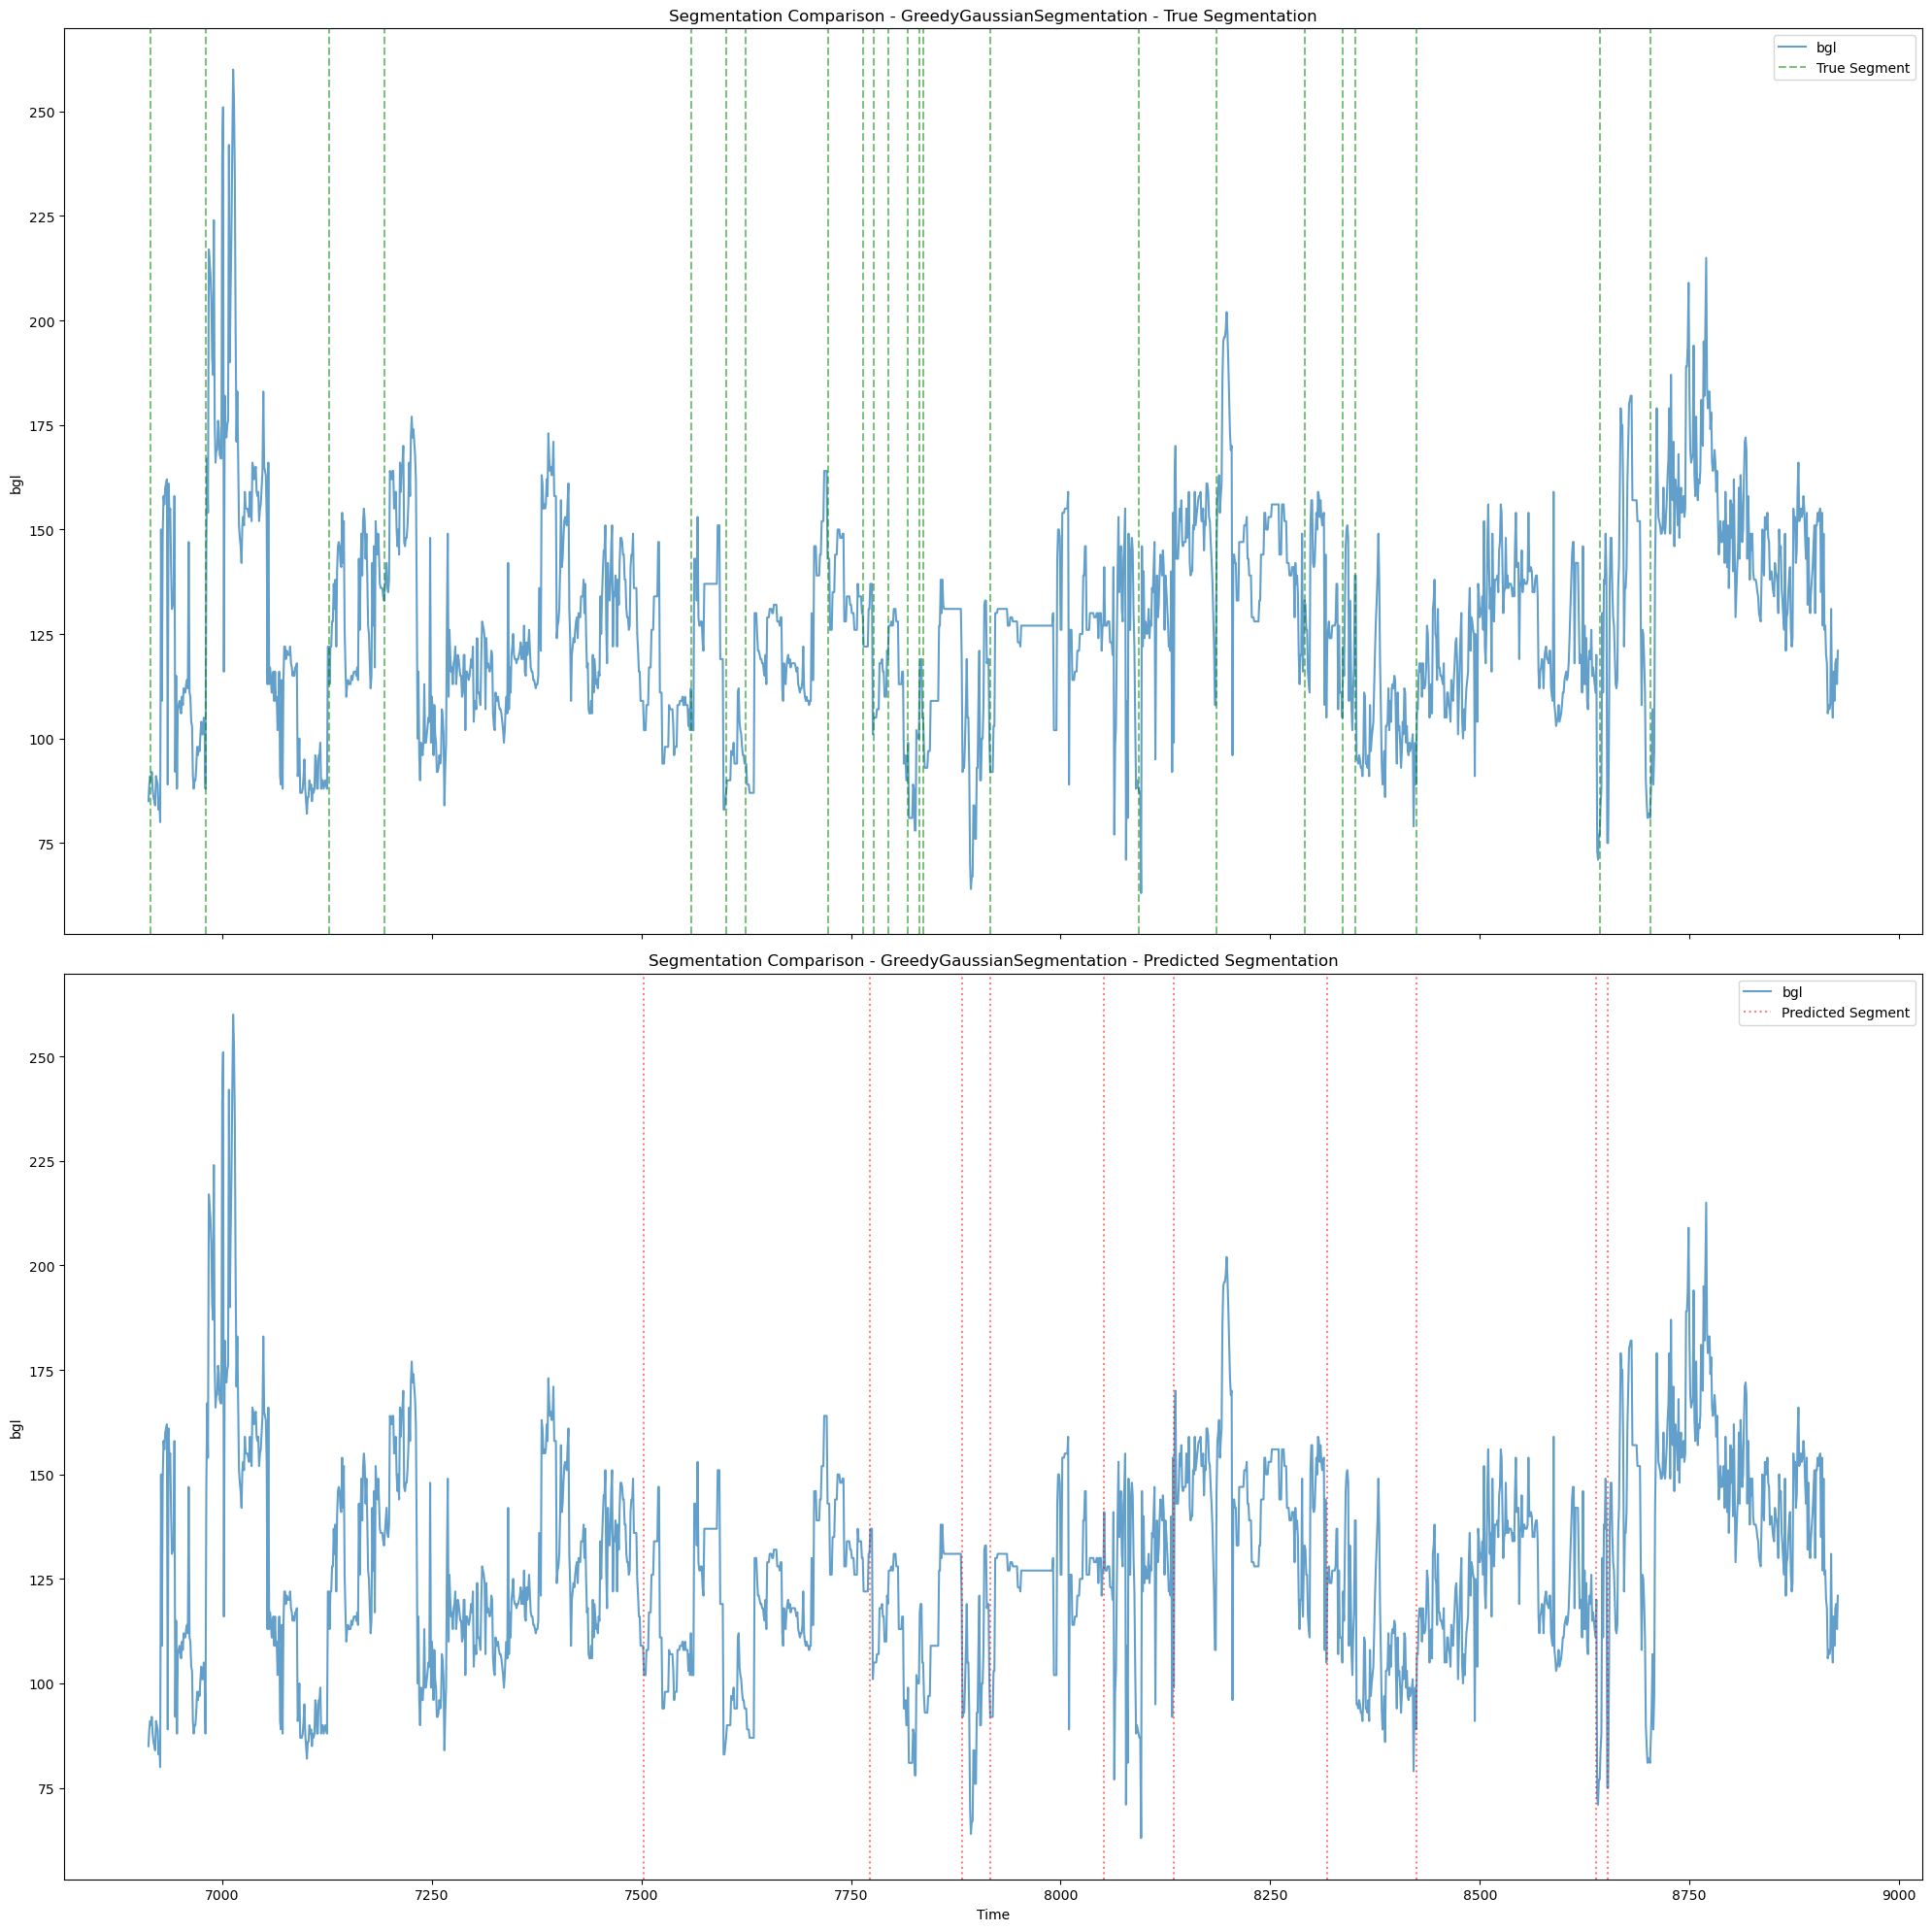

  Created visualization for segmentation comparison - GreedyGaussianSegmentation
Segmentation comparison visualizations have been saved.


In [14]:
X, y = load_and_preprocess_data(num_days)
# loop through the relevant models
print(f"Collected {len(model_classes)} relevant classes:")
for cls in model_classes:
    print(f"- {cls.__name__}")
    if cls.__name__ in model_configs:
        config = model_configs[cls.__name__]
        instance = cls(**config)
        print(f"  Instantiated with config: {config}")
    else:
        print("  No config found, using default parameters")
        instance = cls()
    
    # Fit the model to the data
    try:
        print("Starting fit")
        instance.fit(X, y)
        print(f"  Successfully fit {cls.__name__} to the data")
        
        # Predict
        y_pred = instance.predict(X)
        print(f"  Successfully predicted with {cls.__name__}")
        
        # Visualize predicted and true segmentation in the same plot
        visualize_segmentation(X, y, y_pred, title=f'Segmentation Comparison - {cls.__name__}')
        print(f"  Created visualization for segmentation comparison - {cls.__name__}")
        
    except Exception as e:
        print("============Error============")
        print(f"  Failed to process {cls.__name__}: {str(e)}")
        print("============================")

print("Segmentation comparison visualizations have been saved.")
